# `Third_Paper_dataset_preparation` 

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
from scipy.io.wavfile import write
import librosa
import librosa.display
import pandas as pd
from mir_eval.separation import bss_eval_sources
from pathlib import Path
from pydub import AudioSegment
import csv 
#import directivity package from pyroomacoustics
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
# using datetime module
import datetime;
from tqdm import tqdm
import math
import wave, os, glob

In [30]:
# Ref: https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.room.html#pyroomacoustics.room.Room.add_source
# create a function that accept the azimuth and the colatitude 
def directivityAngle(azi, ele):
    dir_func = CardioidFamily(
        orientation=DirectionVector(azimuth=azi, colatitude=ele, degrees=True),
        pattern_enum=DirectivityPattern.OMNI,
    )
    return dir_func

stept = 1200 #50 ms
speed = 2 #2 m/s
stepd = speed*stept/1000 #moving distance after every loop

In [31]:
df = pd.read_csv (f"data_prep/equipment_scenerios.csv")

In [32]:
df[:5]

,ID,sound_type_1,sound_type_1_no,sound_type_2,sound_type_2_no,ele_1,azi_1,ele_2,azi_2,moving_dir_1,moving_dir_2,Unsafe_1,Unsafe_2,x1_location,y1_location,x2_location,y2_location
0,1,excavator,3,concretepumper,5,30,210,0,140,away,static,No,No,1.5,5.1,6.8,7.3
1,2,crane,0,crane,0,10,165,40,165,away,static,No,No,9.4,1.5,7.8,8.3
2,3,crane,0,excavator,3,0,270,30,215,away,static,No,No,3.4,3.9,1.7,2.2
3,4,concretepumper,5,excavator,3,10,235,40,140,closer,static,Yes,No,1.4,9.4,2.0,2.5
4,5,crane,0,pneumaticbreaker,4,40,215,30,80,closer,static,Yes,No,9.5,11.1,6.3,6.8


In [33]:
# ct stores current time
ct = datetime.datetime.now()
# name of csv file 
# file_name = f"dataset/train_test/metadata_{ct}.csv"

# field names 
fields = ['ID', 'sound_type_1', 'sound_type_2', 'x1_location_1', 
          'y1_location_1', 'y1_location_2', 'y1_location_3', 'y1_location_4', 'x2_location', 'y2_location', 
          'moving_dir_1', 'moving_dir_2', 'Unsafe_1', 'Unsafe_2', 'azi', 'ele'] 

In [38]:
movemix = np.array([])
rangeVal = 100
fields = ["sound_event_recording", "start_time", "end_time", "ele", "azi", "dist"]

for index, row in df[:rangeVal].iterrows():
    randomNums = 4

    mic_locs = np.c_[
        [2.1, 2.6],  # mic 1
        [2., 2.],    # mic 2
    ]
    
    file_name = f"data_prep/metadata_dev/split{randomNums}_ID{row['ID']}_{row['sound_type_1_no']}_vs_{row['sound_type_2_no']}.csv"
    with open(file_name, 'w') as csvfile: 
        csvwriter = csv.writer(csvfile) 
        csvwriter.writerow(fields)
        rows = [[row['sound_type_1'], 0, 5, row['ele_1'], row['azi_1'], round(math.dist([2.1, 2.6],[row['x1_location'], row['y1_location']]), 2)],
                [row['sound_type_2'], 5, 11, row['ele_2'], row['azi_2'], round(math.dist([2.1, 2.6],[row['x2_location'], row['y2_location']]), 2)]
               ] 
        csvwriter.writerows(rows)
      
    sound_type_1 = f"data_prep/audio/{row['sound_type_1']}.wav"
    sound_type_2 = f"data_prep/audio/{row['sound_type_2']}.wav"
    fs_1, sound_1 = wavfile.read(sound_type_1)
    fs_2, sound_2 = wavfile.read(sound_type_2)

    stepn = int(stept*fs_1/1000) 
    n = int(len(sound_1)/stepn)

    Aroom = pra.ShoeBox([100, 100], fs=fs_1, max_order=1, absorption=0.35)
    
    Aroom.add_source([row['x1_location'], row['y1_location']], delay=0., 
                    signal=sound_1, directivity=directivityAngle(row['azi_1'], row['ele_1'])
                   ) 
    Aroom.add_source([row['x2_location'], row['y2_location']], delay=5., 
                    signal=sound_2,
                    directivity=directivityAngle(row['azi_2'], row['ele_2'])
                   ) 
    Aroom.add_microphone(mic_locs)
    Aroom.simulate()

    Aroom.mic_array.to_wav(
        f"data_prep/foa_dev/split{randomNums}_ID{row['ID']}_{row['sound_type_1_no']}_vs_{row['sound_type_2_no']}.wav",
        norm=True,
        bitdepth=np.int16,
    )



In [48]:
audio_path = 'data_prep/foa_dev/split1_ID1_3_vs_5.wav'
# audio_path = 'output/audio/2023-09-27_13-57-28/split5_ID.wav'
# Load as multi-channel data
y_stereo, sr = librosa.load(audio_path, mono=False, sr=16000)
print(y_stereo.shape, sr)
IPython.display.Audio(y_stereo, rate=sr)

(2, 185248) 16000


In [53]:
path = 'data_prep/foa_dev/'
arr = []

for filename in glob.glob(os.path.join(path, '*.wav')):
    #import the audio file using librosa 
    audio, sr = librosa.load(filename, mono=False, sr=16000)
    arr.append(filename)

# arr

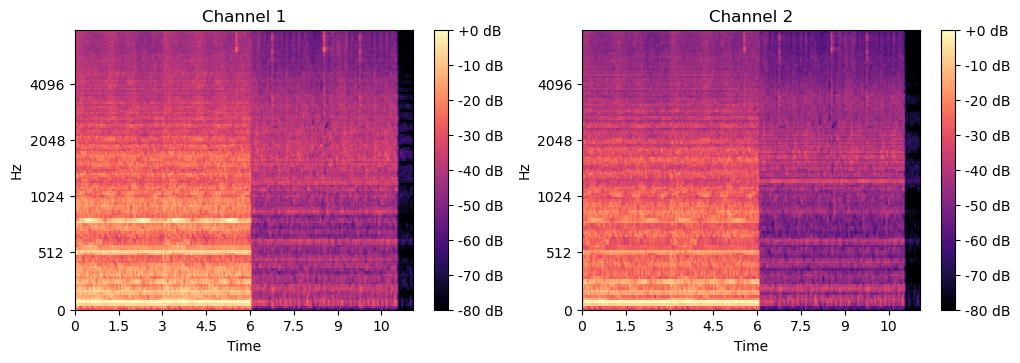

In [65]:
# Calculate the spectrogram
spectrogram = librosa.feature.melspectrogram(y=y_stereo[0], sr=sr)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

spectrogram_ = librosa.feature.melspectrogram(y=y_stereo[1], sr=sr)
spectrogram_db_ = librosa.power_to_db(spectrogram_, ref=np.max)


# Create a 2x2 grid of subplots
plt.figure(figsize=(12, 8))

# Subplot 1
plt.subplot(2, 2, 1)
librosa.display.specshow(spectrogram_db, x_axis='time', y_axis='mel', sr=sr, cmap='magma')
plt.title('Channel 1')
plt.colorbar(format='%+2.0f dB')

# Subplot 2
plt.subplot(2, 2, 2)
librosa.display.specshow(spectrogram_db_, x_axis='time', y_axis='mel', sr=sr, cmap='magma')
plt.title('Channel 2')
plt.colorbar(format='%+2.0f dB')